In [9]:
from __future__ import print_function, division

% matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import math
import numpy as np

from thinkbayes2 import Pmf, Cdf, Suite, Joint
import thinkplot

### Bug Testing Problem

Let's apply this to the Lincoln index problem from John D. Cook:

"Suppose you have a tester who finds 20 bugs in your program. You want to estimate how many bugs are really in the program. You know there are at least 20 bugs, and if you have supreme confidence in your tester, you may suppose there are around 20 bugs. But maybe your tester isn't very good. Maybe there are hundreds of bugs. How can you have any idea how many bugs there are? There’s no way to know with one tester. But if you have two testers, you can get a good idea, even if you don’t know how skilled the testers are.

"Suppose two testers independently search for bugs. Let k1 be the number of errors the first tester finds and k2 the number of errors the second tester finds. Let c be the number of errors both testers find. The Lincoln Index estimates the total number of errors as k1 k2 / c [I changed his notation to be consistent with mine]."

So if the first tester finds 20 bugs, the second finds 15, and they find 3 in common, we estimate that there are about 100 bugs. What is the Bayesian estimate of the number of errors based on this data?

<pre>
[ p1, p2, n ] -> [ k1, k2, c ]

p1 = P(tester #1 find any given bug)
p2 = P(tester #2 find any given bug)
n = number of bugs

---

k1 = # bugs found by tester 1
k2 = # bugs found by tester 2
c = number of duplicate bugs
</pre>

In [10]:
n = 100
p1 = 0.2
p2 = 0.1

p1_bugs = np.random.random(n) < p1
p2_bugs = np.random.random(n) < p2

print('k1 \t= {}'.format(np.sum(p1_bugs)))

print('k2 \t= {}'.format(np.sum(p2_bugs)))

print('c \t= {}'.format(np.sum(p1_bugs & p2_bugs)))

k1 	= 17
k2 	= 9
c 	= 1


<pre>
k1 ~ Binom(n, p1)
k2 ~ Binom(n, p2)
c ~ ?
</pre>

In [15]:
import scipy.stats as stats


class BugLife(Suite):
    def Likelihood(self, data, hypo):
        k1, k2, c = data
        n, p1, p2 = hypo
        
        like1 = stats.binom.pmf(k1, n, p1)
        like2 = stats.binom.pmf(k2, n, p2)
        
        
        return like1 * like2

ns = range(0, 10)
p1s = np.linspace(0,1, 101)
p2s = np.linspace(0,1, 101)

priors = [(n, p1, p2) for n in ns
         for p1 in p1s
         for p2 in p2s]
    
BugLife(priors).Update((3, 2, 0))

0.018615804692740087

In [12]:
class P:
    def __init__(self, of, given=None):
        self.of = of
        self.given = given
    
    def __or__(self, other):
        """
        Probability of self given other
        P(self | other)
        """
        a = self
        if self.given == None:
            a = self.of
            
        b = other
        if other.given == None:
            b = other.of
        
        return P(a, b)
    
    def __str__(self):
        if self.given != None:
            return 'P({} | {})'.format(
                self.of,
                self.given
            )
        return 'P({})'.format(self.of)
        

apples = P('apples')
oranges = P('oranges')

print(apples | oranges)

P(apples | oranges)


In [105]:
from IPython.core.display import HTML
def css_styling():
    styles = """
    <style>
    table.sudoku {
      margin:1em auto;
      border-spacing: 0;
    }
    .sudoku td {
      height:30px;
      width:30px;
      border:1px solid;
      text-align:center;
      padding: 0;
    }
    .sudoku td:first-child {
      border-left:solid;
    }
    .sudoku td:nth-child(3n) {
      border-right:solid ;
    }
    .sudoku tr:first-child {
      border-top:solid;
    }
    .sudoku tr:nth-child(3n) td {
      border-bottom:solid ;
    }

    .sudoku td > table {
        border: 0 !important;
    }
    .sudoku td > table tr {
        border: 0 !important;
    }
    .sudoku td > table td {
        border: 0 !important;
        width: 23px;
        height: 9px;
    }
    </style>
    """
    return HTML(styles)
css_styling()

## Sudoku

<table class="sudoku">
  <caption>Sudoku of the day</caption>
  <tbody>
   <tr> <td>1 <td>  <td>3 <td>6 <td>  <td>4 <td>7 <td>  <td>9
   <tr> <td>  <td>2 <td>  <td>  <td>9 <td>  <td>  <td>1 <td>
   <tr> <td>7 <td>  <td>  <td>  <td>  <td>  <td>  <td>  <td>6
   <tr> <td>2 <td>  <td>4 <td>  <td>3 <td>  <td>9 <td>  <td>8
   <tr> <td>  <td>  <td>  <td>  <td>  <td>  <td>  <td>  <td>
   <tr> <td>5 <td>  <td>  <td>9 <td>  <td>7 <td>  <td>  <td>1
   <tr> <td>6 <td>  <td>  <td>  <td>5 <td>  <td>  <td>  <td>2
   <tr> <td>  <td>  <td>  <td>  <td>7 <td>  <td>  <td>  <td>
   <tr> <td>9 <td>  <td>  <td>8 <td>  <td>2 <td>  <td>  <td>5
   </tbody>
</table>

In [207]:
class Sudoku(Suite, Joint):
    def __init__(self):
        """Makes a joint suite of parameters 

        Enumerates all pairs of alpha and beta.
        Stores locations for use in Likelihood.

        alphas: possible values for alpha
        betas: possible values for beta
        """
        self.grid = np.zeros((9,9))
        self.columns = range(9)
        self.rows = range(9)
        self.numbers = range(1,10)
        
        # make every possibility
        hypos = [(row, column, number) 
                 for column in self.columns 
                 for row in self.rows
                 for number in self.numbers]
        Suite.__init__(self, hypos)
    
    def get_cell_hypos(self, row, column):
        # let's get the hypothetical values
        hypos = self.GetDict()
        
        cell_possible_numbers = np.zeros(9)
        
        for number in self.numbers:
            cell_possible_numbers[number - 1] = hypos[(row, column, number)]
        
        return np.reshape(cell_possible_numbers, (3, 3))
    
    def _render_cell(self, row, column, max_like=1):
        value = self.grid[row, column]
        
        if value != 0:
            # final value
            return '{}'.format(int(value))
        
        cell_hypos = self.get_cell_hypos(row, column)
    
        
        html = [
            '<tr>{}</tr>'.format(
                ''.join([
                        '<td style="background-color: rgba(0,0,0,{})"></td>'.format(c ** max_like) for c in r
                    ])
            ) for r in cell_hypos
        ]
        
        return '<table>{}</table>'.format(''.join(html))
            
    
    def _repr_html_(self):
        maximum_like = max(self.GetDict(), key=self.GetDict().get)
        
        html = ''
        for row in self.rows:
            cols = []
            for column in self.columns:
                cols.append(
                    '<td>{}</td>'.format(
                        self._render_cell(row, column, max_like=self.GetDict()[maximum_like])
                    )
                )
            html += '<tr>{}</tr>'.format(''.join(cols))
        
        
        return '<table class="sudoku">{}</table>'.format(html)
    
    def numbers_html(self, numbers):
        return str(numbers);
    
    def SubLikelihood(self, guess, filled_numbers):
        if guess in filled_numbers:
            return 0
        
        empty_spaces = len(filled_numbers) - np.count_nonzero(filled_numbers)

        return 1 / empty_spaces
    
    def Likelihood(self, data, hypo):
        new_row, new_column, new_number = data
        self.grid[new_row, new_column] = new_number # save them

        hypo_row, hypo_column, hypo_number = hypo
        
        current_number = self.grid[hypo_row, hypo_column]
        if current_number != 0: # value is known, cannot be overwritten
            return 1 if current_number == hypo_number else 0
        
        #         if hypo_row != new_row and hypo_column != new_column:
        #             return 0.1
        
        square_row = hypo_row // 3
        square_column = hypo_column // 3
        
        square = self.grid[
            square_row * 3 : (square_row + 1) * 3,
            square_column * 3 : (square_column + 1) * 3
        ]
        
        
        
        like_square = self.SubLikelihood(
            hypo_number,
            square.flatten()
        )
        
        like_column = self.SubLikelihood(
            hypo_number,
            self.grid[hypo_row].flatten()
        )
        
        like_row = self.SubLikelihood(
            hypo_number,
            self.grid[:, hypo_column].flatten()
        )
        
        return like_square * like_column * like_row

In [209]:
ok = Sudoku()

# ok.grid = np.array([
#         [1,	0,	3,	6,	0,	4,	7,	0,	9],
#         [0,	2,	0,	0,	9,	0,	0,	1,	0],
#         [7,	0,	0,	0,	0,	0,	0,	0,	6],
#         [2,	0,	4,	0,	3,	0,	9,	0,	8],
#         [0,	0,	0,	0,	0,	0,	0,	0,	0],
#         [5,	0,	0,	9,	0,	7,	0,	0,	1],
#         [6,	0,	0,	0,	5,	0,	0,	0,	2],
#         [0,	0,	0,	0,	7,	0,	0,	0,	0],
#         [9,	0,	0,	8,	0,	2,	0,	0,	5]
#     ])

ok.Update((0,0,1))
# ok.Update((4,8,7))
ok

Sudoku({(0, 5, 5): 0.0007739938080495388, (1, 2, 8): 0.0007739938080495388, (3, 0, 3): 0.0007739938080495388, (1, 4, 4): 0.0006879944960440344, (7, 1, 3): 0.0006879944960440344, (0, 0, 8): 0.0, (4, 7, 6): 0.0006879944960440344, (8, 5, 9): 0.0006879944960440344, (2, 8, 2): 0.0006879944960440344, (5, 2, 1): 0.0006879944960440344, (0, 2, 1): 0.0, (8, 0, 2): 0.0007739938080495388, (1, 7, 2): 0.0006879944960440344, (2, 6, 7): 0.0006879944960440344, (8, 6, 2): 0.0006879944960440344, (2, 0, 7): 0.0008707430340557311, (4, 1, 2): 0.0006879944960440344, (4, 2, 8): 0.0006879944960440344, (5, 5, 5): 0.0006879944960440344, (3, 1, 4): 0.0006879944960440344, (6, 5, 7): 0.0006879944960440344, (8, 8, 7): 0.0006879944960440344, (6, 0, 6): 0.0007739938080495388, (8, 3, 4): 0.0006879944960440344, (1, 6, 3): 0.0006879944960440344, (2, 5, 3): 0.0006879944960440344, (0, 1, 8): 0.0008707430340557311, (0, 7, 4): 0.0007739938080495388, (6, 6, 3): 0.0006879944960440344, (5, 2, 9): 0.0006879944960440344, (3, 2, 6): 0.0006879944960440344, (7, 3, 4): 0.0006879944960440344, (3, 8, 6): 0.0006879944960440344, (4, 1, 1): 0.0006879944960440344, (7, 4, 7): 0.0006879944960440344, (0, 4, 2): 0.0007739938080495388, (1, 3, 7): 0.0006879944960440344, (1, 5, 7): 0.0006879944960440344, (2, 4, 8): 0.0006879944960440344, (7, 6, 2): 0.0006879944960440344, (1, 8, 4): 0.0006879944960440344, (3, 7, 8): 0.0006879944960440344, (4, 6, 5): 0.0006879944960440344, (5, 8, 7): 0.0006879944960440344, (3, 1, 8): 0.0006879944960440344, (5, 3, 6): 0.0006879944960440344, (1, 0, 3): 0.0008707430340557311, (8, 5, 3): 0.0006879944960440344, (2, 3, 6): 0.0006879944960440344, (4, 1, 9): 0.0006879944960440344, (5, 6, 4): 0.0006879944960440344, (6, 4, 4): 0.0006879944960440344, (8, 7, 6): 0.0006879944960440344, (5, 0, 8): 0.0007739938080495388, (3, 4, 1): 0.0006879944960440344, (6, 3, 7): 0.0006879944960440344, (8, 2, 7): 0.0006879944960440344, (0, 0, 7): 0.0, (0, 6, 7): 0.0007739938080495388, (1, 1, 8): 0.0007739938080495388, (6, 1, 2): 0.0006879944960440344, (3, 3, 5): 0.0006879944960440344, (2, 2, 9): 0.0007739938080495388, (7, 0, 5): 0.0007739938080495388, (4, 0, 6): 0.0007739938080495388, (5, 7, 3): 0.0006879944960440344, (7, 5, 8): 0.0006879944960440344, (5, 1, 3): 0.0006879944960440344, (0, 3, 3): 0.0007739938080495388, (1, 6, 6): 0.0006879944960440344, (2, 7, 9): 0.0006879944960440344, (7, 7, 1): 0.0006879944960440344, (3, 4, 9): 0.0006879944960440344, (4, 5, 4): 0.0006879944960440344, (2, 1, 5): 0.0007739938080495388, (6, 0, 9): 0.0007739938080495388, (4, 3, 8): 0.0006879944960440344, (5, 4, 7): 0.0006879944960440344, (2, 8, 5): 0.0006879944960440344, (8, 4, 4): 0.0006879944960440344, (2, 2, 1): 0.0, (0, 2, 8): 0.0008707430340557311, (8, 0, 9): 0.0007739938080495388, (1, 7, 9): 0.0006879944960440344, (6, 7, 5): 0.0006879944960440344, (7, 4, 8): 0.0006879944960440344, (3, 5, 6): 0.0006879944960440344, (4, 4, 3): 0.0006879944960440344, (7, 2, 4): 0.0006879944960440344, (6, 2, 8): 0.0006879944960440344, (8, 1, 6): 0.0006879944960440344, (2, 7, 1): 0.0006879944960440344, (0, 5, 6): 0.0007739938080495388, (1, 2, 9): 0.0007739938080495388, (6, 0, 1): 0.0, (3, 0, 4): 0.0007739938080495388, (1, 4, 5): 0.0006879944960440344, (2, 5, 8): 0.0006879944960440344, (7, 1, 2): 0.0006879944960440344, (3, 6, 8): 0.0006879944960440344, (4, 7, 7): 0.0006879944960440344, (5, 2, 2): 0.0006879944960440344, (8, 0, 1): 0.0, (1, 7, 1): 0.0006879944960440344, (2, 6, 6): 0.0006879944960440344, (8, 2, 2): 0.0006879944960440344, (2, 0, 6): 0.0008707430340557311, (0, 4, 9): 0.0007739938080495388, (6, 3, 8): 0.0006879944960440344, (5, 5, 4): 0.0006879944960440344, (3, 1, 3): 0.0006879944960440344, (6, 5, 4): 0.0006879944960440344, (8, 8, 6): 0.0006879944960440344, (3, 7, 3): 0.0006879944960440344, (1, 2, 1): 0.0, (8, 3, 5): 0.0006879944960440344, (0, 1, 9): 0.0008707430340557311, (0, 7, 5): 0.0007739938080495388, (1, 0, 8): 0.0008707430340557311, (6, 6, 2): 0.0006879944960440344, (8, 5, 4): 0.0006879944960440344, (3, 

In [206]:
max(x, key=x.get)

x[max(x, key=x.get)]

0.5015479876161012

In [203]:
ok = Sudoku()

ok.grid = np.array([
        [1,	0,	3,	6,	0,	4,	7,	0,	9],
        [0,	2,	0,	0,	9,	0,	0,	1,	0],
        [7,	0,	0,	0,	0,	0,	0,	0,	6],
        [2,	0,	4,	0,	3,	0,	9,	0,	8],
        [0,	0,	0,	0,	0,	0,	0,	0,	0],
        [5,	0,	0,	9,	0,	7,	0,	0,	1],
        [6,	0,	0,	0,	5,	0,	0,	0,	2],
        [0,	0,	0,	0,	7,	0,	0,	0,	0],
        [9,	0,	0,	8,	0,	2,	0,	0,	5]
    ])

ok.Update((0,0,1))

ok.Update((4,8,7))


results = ok.GetDict()


ok

[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   2.47922428e-06   0.00000000e+00]
 [  0.00000000e+00   2.47922428e-06   0.00000000e+00]] 0.035700829569110894
[[  0.00000000e+00   4.40750982e-06   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.40750982e-06   0.00000000e+00]] 0.035700829569110894
[[  0.00000000e+00   2.47922428e-06   0.00000000e+00]
 [  0.00000000e+00   2.47922428e-06   0.00000000e+00]
 [  0.00000000e+00   2.47922428e-06   0.00000000e+00]] 0.035700829569110894
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  4.40750982e-06   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   4.40750982e-06   0.00000000e+00]] 0.035700829569110894
[[  0.00000000e+00   0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   8.09542621e-07   8.09542621e-07]
 [  0.00000000e+00   8.09542621e-07   0.00000000e+00]] 0.035700829569110894
[[  0.00000000e+00   0.00000000e+00   7.65192678e-07]
 [  0.00000000e+00   7.651

Sudoku({(0, 5, 5): 0.0, (1, 2, 8): 8.095426206147594e-07, (3, 0, 3): 0.0, (1, 4, 4): 0.0, (7, 1, 3): 1.7787801722492275e-07, (0, 0, 8): 0.0, (4, 7, 6): 2.5825252871173975e-07, (8, 5, 9): 0.0, (2, 8, 2): 0.0, (5, 2, 1): 0.0, (0, 2, 1): 0.0, (8, 0, 2): 0.0, (1, 7, 2): 0.0, (2, 6, 7): 0.0, (8, 6, 2): 0.0, (2, 0, 7): 0.035700829569110894, (4, 1, 2): 0.0, (4, 2, 8): 2.8109118771345813e-07, (5, 5, 5): 0.0, (3, 1, 4): 0.0, (6, 5, 7): 0.0, (8, 8, 7): 0.0, (6, 0, 6): 0.035700829569110894, (8, 3, 4): 0.0, (1, 6, 3): 8.095426206147594e-07, (2, 5, 3): 5.621823754269163e-07, (0, 1, 8): 2.479224275632701e-06, (0, 7, 4): 0.0, (6, 6, 3): 4.1303194929324457e-07, (5, 2, 9): 0.0, (3, 2, 6): 0.0, (7, 3, 4): 6.198060689081752e-07, (3, 8, 6): 0.0, (4, 1, 1): 2.1521044059311644e-07, (7, 4, 7): 0.035700829569110894, (0, 4, 2): 4.407509823347025e-06, (1, 3, 7): 7.651926776644139e-07, (1, 5, 7): 0.0, (2, 4, 8): 8.095426206147596e-07, (7, 6, 2): 0.0, (1, 8, 4): 6.611264735020536e-06, (3, 7, 8): 0.0, (4, 6, 5): 3.373094252561498e-07, (5, 8, 7): 0.0, (3, 1, 8): 0.0, (5, 3, 6): 0.0, (1, 0, 3): 0.0, (8, 5, 3): 0.0, (2, 3, 6): 0.0, (4, 1, 9): 2.1521044059311644e-07, (5, 6, 4): 9.714511447377116e-07, (6, 4, 4): 0.0, (8, 7, 6): 4.5536772409580227e-07, (5, 0, 8): 0.0, (3, 4, 1): 0.0, (6, 3, 7): 0.0, (8, 2, 7): 5.947660069822721e-07, (0, 0, 7): 0.0, (0, 6, 7): 0.035700829569110894, (1, 1, 8): 0.0, (6, 1, 2): 0.0, (3, 3, 5): 1.7216835247449313e-06, (2, 2, 9): 5.947660069822721e-07, (7, 0, 5): 0.0, (4, 0, 6): 0.0, (5, 7, 3): 7.437672826898103e-07, (7, 5, 8): 0.0, (5, 1, 3): 6.198060689081752e-07, (0, 3, 3): 0.0, (1, 6, 6): 0.0, (2, 7, 9): 0.0, (7, 7, 1): 0.0, (3, 4, 9): 0.0, (4, 5, 4): 0.0, (2, 1, 5): 4.5536772409580227e-07, (6, 0, 9): 0.0, (4, 3, 8): 0.0, (5, 4, 7): 0.0, (2, 8, 5): 0.0, (8, 4, 4): 2.2848530924230985e-06, (2, 2, 1): 0.0, (0, 2, 8): 0.0, (8, 0, 9): 0.035700829569110894, (1, 7, 9): 0.0, (6, 7, 5): 0.0, (7, 4, 8): 0.0, (3, 5, 6): 1.7216835247449313e-06, (4, 4, 3): 0.0, (7, 2, 4): 0.0, (6, 2, 8): 4.1303194929324457e-07, (8, 1, 6): 0.0, (2, 7, 1): 0.0, (0, 5, 6): 0.0, (1, 2, 9): 0.0, (6, 0, 1): 0.0, (3, 0, 4): 0.0, (1, 4, 5): 0.0, (2, 5, 8): 5.621823754269163e-07, (7, 1, 2): 0.0, (3, 6, 8): 0.0, (4, 7, 7): 0.0, (5, 2, 2): 0.0, (8, 0, 1): 0.0, (1, 7, 1): 0.035700829569110894, (2, 6, 6): 0.0, (8, 2, 2): 0.0, (2, 0, 6): 0.0, (0, 4, 9): 0.0, (6, 3, 8): 0.0, (5, 5, 4): 0.0, (3, 1, 3): 0.0, (6, 5, 4): 0.0, (8, 8, 6): 0.0, (3, 7, 3): 0.0, (1, 2, 1): 0.0, (8, 3, 5): 0.0, (0, 1, 9): 0.0, (0, 7, 5): 2.479224275632701e-06, (1, 0, 8): 4.407509823347023e-06, (6, 6, 2): 0.0, (8, 5, 4): 0.0, (3, 2, 7): 0.0, (7, 3, 7): 0.0, (3, 8, 7): 0.0, (0, 8, 9): 0.035700829569110894, (5, 0, 1): 0.0, (0, 4, 1): 0.0, (1, 3, 6): 0.0, (1, 5, 6): 0.0, (7, 6, 3): 2.3233047147745008e-07, (1, 8, 5): 0.0, (4, 6, 4): 3.373094252561498e-07, (5, 8, 4): 0.0, (5, 3, 5): 0.0, (0, 1, 1): 0.0, (2, 3, 7): 0.0, (0, 3, 8): 0.0, (6, 2, 7): 4.1303194929324457e-07, (0, 8, 1): 0.0, (5, 6, 5): 0.0, (7, 7, 8): 1.7787801722492275e-07, (6, 4, 7): 0.0, (8, 7, 7): 4.5536772409580227e-07, (5, 0, 9): 0.0, (3, 4, 2): 0.0, (4, 3, 1): 3.825963388322069e-07, (2, 4, 3): 0.0, (0, 0, 6): 0.0, (0, 6, 6): 0.0, (6, 1, 3): 3.1622758617764044e-07, (8, 4, 3): 0.0, (3, 3, 4): 0.0, (2, 2, 8): 5.947660069822721e-07, (7, 0, 6): 0.0, (4, 8, 5): 0.0, (7, 7, 4): 1.7787801722492275e-07, (4, 0, 5): 0.0, (5, 7, 2): 7.437672826898103e-07, (5, 1, 2): 0.0, (1, 6, 7): 0.0, (4, 8, 2): 0.0, (4, 3, 5): 3.825963388322069e-07, (8, 2, 6): 0.0, (4, 5, 5): 3.825963388322069e-07, (2, 1, 2): 0.0, (6, 0, 8): 0.0, (4, 3, 9): 0.0, (5, 4, 4): 1.586703536404929e-06, (8, 2, 5): 0.0, (7, 1, 9): 0.0, (3, 6, 1): 0.0, (1, 1, 3): 0.0, (2, 8, 4): 0.0, (3, 8, 8): 0.035700829569110894, (8, 0, 8): 0.0, (1, 7, 8): 0.0, (6, 7, 6): 0.0, (8, 6, 4): 5.947660069822721e-07, (3, 5, 5): 1.7216835247449313e-06, (4, 4, 2): 5.50938727918378e-07, (2, 0, 9): 0.0, (7, 2, 5): 2.3233047147745008e-07, (8, 1, 7): 4.5536772409580227e-07, (2, 7, 2): 4.5536772409580227e-07, (0, 5, 7)

In [151]:
results

{(0, 0, 1): 0.035700829569110894,
 (0, 0, 2): 0.0,
 (0, 0, 3): 0.0,
 (0, 0, 4): 0.0,
 (0, 0, 5): 0.0,
 (0, 0, 6): 0.0,
 (0, 0, 7): 0.0,
 (0, 0, 8): 0.0,
 (0, 0, 9): 0.0,
 (0, 1, 1): 0.0,
 (0, 1, 2): 0.0,
 (0, 1, 3): 0.0,
 (0, 1, 4): 0.0,
 (0, 1, 5): 2.479224275632701e-06,
 (0, 1, 6): 0.0,
 (0, 1, 7): 0.0,
 (0, 1, 8): 2.479224275632701e-06,
 (0, 1, 9): 0.0,
 (0, 2, 1): 0.0,
 (0, 2, 2): 0.0,
 (0, 2, 3): 0.035700829569110894,
 (0, 2, 4): 0.0,
 (0, 2, 5): 0.0,
 (0, 2, 6): 0.0,
 (0, 2, 7): 0.0,
 (0, 2, 8): 0.0,
 (0, 2, 9): 0.0,
 (0, 3, 1): 0.0,
 (0, 3, 2): 0.0,
 (0, 3, 3): 0.0,
 (0, 3, 4): 0.0,
 (0, 3, 5): 0.0,
 (0, 3, 6): 0.035700829569110894,
 (0, 3, 7): 0.0,
 (0, 3, 8): 0.0,
 (0, 3, 9): 0.0,
 (0, 4, 1): 0.0,
 (0, 4, 2): 4.407509823347025e-06,
 (0, 4, 3): 0.0,
 (0, 4, 4): 0.0,
 (0, 4, 5): 0.0,
 (0, 4, 6): 0.0,
 (0, 4, 7): 0.0,
 (0, 4, 8): 4.407509823347025e-06,
 (0, 4, 9): 0.0,
 (0, 5, 1): 0.0,
 (0, 5, 2): 0.0,
 (0, 5, 3): 0.0,
 (0, 5, 4): 0.035700829569110894,
 (0, 5, 5): 0.0,
 (0, 5, 6)

In [182]:
s = Sudoku()

s.Update((0,0,9))

s

Sudoku({(0, 5, 5): 0.0007739938080495388, (1, 2, 8): 0.0007739938080495388, (3, 0, 3): 0.0007739938080495388, (1, 4, 4): 0.0006879944960440344, (7, 1, 3): 0.0006879944960440344, (0, 0, 8): 0.0, (4, 7, 6): 0.0006879944960440344, (8, 5, 9): 0.0006879944960440344, (2, 8, 2): 0.0006879944960440344, (5, 2, 1): 0.0006879944960440344, (0, 2, 1): 0.0008707430340557311, (8, 0, 2): 0.0007739938080495388, (1, 7, 2): 0.0006879944960440344, (2, 6, 7): 0.0006879944960440344, (8, 6, 2): 0.0006879944960440344, (2, 0, 7): 0.0008707430340557311, (4, 1, 2): 0.0006879944960440344, (4, 2, 8): 0.0006879944960440344, (5, 5, 5): 0.0006879944960440344, (3, 1, 4): 0.0006879944960440344, (6, 5, 7): 0.0006879944960440344, (8, 8, 7): 0.0006879944960440344, (6, 0, 6): 0.0007739938080495388, (8, 3, 4): 0.0006879944960440344, (1, 6, 3): 0.0006879944960440344, (2, 5, 3): 0.0006879944960440344, (0, 1, 8): 0.0008707430340557311, (0, 7, 4): 0.0007739938080495388, (6, 6, 3): 0.0006879944960440344, (5, 2, 9): 0.0006879944960440344, (3, 2, 6): 0.0006879944960440344, (7, 3, 4): 0.0006879944960440344, (3, 8, 6): 0.0006879944960440344, (4, 1, 1): 0.0006879944960440344, (7, 4, 7): 0.0006879944960440344, (0, 4, 2): 0.0007739938080495388, (1, 3, 7): 0.0006879944960440344, (1, 5, 7): 0.0006879944960440344, (2, 4, 8): 0.0006879944960440344, (7, 6, 2): 0.0006879944960440344, (1, 8, 4): 0.0006879944960440344, (3, 7, 8): 0.0006879944960440344, (4, 6, 5): 0.0006879944960440344, (5, 8, 7): 0.0006879944960440344, (3, 1, 8): 0.0006879944960440344, (5, 3, 6): 0.0006879944960440344, (1, 0, 3): 0.0008707430340557311, (8, 5, 3): 0.0006879944960440344, (2, 3, 6): 0.0006879944960440344, (4, 1, 9): 0.0006879944960440344, (5, 6, 4): 0.0006879944960440344, (6, 4, 4): 0.0006879944960440344, (8, 7, 6): 0.0006879944960440344, (5, 0, 8): 0.0007739938080495388, (3, 4, 1): 0.0006879944960440344, (6, 3, 7): 0.0006879944960440344, (8, 2, 7): 0.0006879944960440344, (0, 0, 7): 0.0, (0, 6, 7): 0.0007739938080495388, (1, 1, 8): 0.0007739938080495388, (6, 1, 2): 0.0006879944960440344, (3, 3, 5): 0.0006879944960440344, (2, 2, 9): 0.0, (7, 0, 5): 0.0007739938080495388, (4, 0, 6): 0.0007739938080495388, (5, 7, 3): 0.0006879944960440344, (7, 5, 8): 0.0006879944960440344, (5, 1, 3): 0.0006879944960440344, (0, 3, 3): 0.0007739938080495388, (1, 6, 6): 0.0006879944960440344, (2, 7, 9): 0.0006879944960440344, (7, 7, 1): 0.0006879944960440344, (3, 4, 9): 0.0006879944960440344, (4, 5, 4): 0.0006879944960440344, (2, 1, 5): 0.0007739938080495388, (6, 0, 9): 0.0, (4, 3, 8): 0.0006879944960440344, (5, 4, 7): 0.0006879944960440344, (2, 8, 5): 0.0006879944960440344, (8, 4, 4): 0.0006879944960440344, (2, 2, 1): 0.0007739938080495388, (0, 2, 8): 0.0008707430340557311, (8, 0, 9): 0.0, (1, 7, 9): 0.0006879944960440344, (6, 7, 5): 0.0006879944960440344, (7, 4, 8): 0.0006879944960440344, (3, 5, 6): 0.0006879944960440344, (4, 4, 3): 0.0006879944960440344, (7, 2, 4): 0.0006879944960440344, (6, 2, 8): 0.0006879944960440344, (8, 1, 6): 0.0006879944960440344, (2, 7, 1): 0.0006879944960440344, (0, 5, 6): 0.0007739938080495388, (1, 2, 9): 0.0, (6, 0, 1): 0.0007739938080495388, (3, 0, 4): 0.0007739938080495388, (1, 4, 5): 0.0006879944960440344, (2, 5, 8): 0.0006879944960440344, (7, 1, 2): 0.0006879944960440344, (3, 6, 8): 0.0006879944960440344, (4, 7, 7): 0.0006879944960440344, (5, 2, 2): 0.0006879944960440344, (8, 0, 1): 0.0007739938080495388, (1, 7, 1): 0.0006879944960440344, (2, 6, 6): 0.0006879944960440344, (8, 2, 2): 0.0006879944960440344, (2, 0, 6): 0.0008707430340557311, (0, 4, 9): 0.0, (6, 3, 8): 0.0006879944960440344, (5, 5, 4): 0.0006879944960440344, (3, 1, 3): 0.0006879944960440344, (6, 5, 4): 0.0006879944960440344, (8, 8, 6): 0.0006879944960440344, (3, 7, 3): 0.0006879944960440344, (1, 2, 1): 0.0007739938080495388, (8, 3, 5): 0.0006879944960440344, (0, 1, 9): 0.0, (0, 7, 5): 0.0007739938080495388, (1, 0, 8): 0.0008707430340557311, (6, 6, 2): 0.0006879944960440344, (8, 5, 4): 0.0006879944960440344, (3, 2, 7): 0.000687994

In [125]:
s.Update((8,8,6))

s

Sudoku({(0, 5, 5): 2.374894358431862e-06, (1, 2, 8): 2.374894358431862e-06, (3, 0, 3): 2.374894358431862e-06, (1, 4, 4): 1.876459739995545e-06, (7, 1, 3): 1.876459739995545e-06, (0, 0, 8): 0.0, (4, 7, 6): 1.876459739995545e-06, (8, 5, 9): 2.1110172074949883e-06, (2, 8, 2): 2.1110172074949883e-06, (5, 2, 1): 1.876459739995545e-06, (0, 2, 1): 3.005725672390325e-06, (8, 0, 2): 2.6717561532358445e-06, (1, 7, 2): 1.876459739995545e-06, (2, 6, 7): 1.876459739995545e-06, (8, 6, 2): 2.374894358431862e-06, (2, 0, 7): 3.005725672390325e-06, (4, 1, 2): 1.876459739995545e-06, (4, 2, 8): 1.876459739995545e-06, (5, 5, 5): 1.876459739995545e-06, (3, 1, 4): 1.876459739995545e-06, (6, 5, 7): 1.876459739995545e-06, (8, 8, 7): 0.0, (6, 0, 6): 2.374894358431862e-06, (8, 3, 4): 2.1110172074949883e-06, (1, 6, 3): 1.876459739995545e-06, (2, 5, 3): 1.876459739995545e-06, (0, 1, 8): 3.005725672390325e-06, (0, 7, 4): 2.374894358431862e-06, (6, 6, 3): 2.1110172074949883e-06, (5, 2, 9): 1.876459739995545e-06, (3, 2, 6): 1.876459739995545e-06, (7, 3, 4): 1.876459739995545e-06, (3, 8, 6): 0.0, (4, 1, 1): 1.876459739995545e-06, (7, 4, 7): 1.876459739995545e-06, (0, 4, 2): 2.374894358431862e-06, (1, 3, 7): 1.876459739995545e-06, (1, 5, 7): 1.876459739995545e-06, (2, 4, 8): 1.876459739995545e-06, (7, 6, 2): 2.1110172074949883e-06, (1, 8, 4): 2.1110172074949883e-06, (3, 7, 8): 1.876459739995545e-06, (4, 6, 5): 1.876459739995545e-06, (5, 8, 7): 2.1110172074949883e-06, (3, 1, 8): 1.876459739995545e-06, (5, 3, 6): 1.876459739995545e-06, (1, 0, 3): 3.005725672390325e-06, (8, 5, 3): 2.1110172074949883e-06, (2, 3, 6): 1.876459739995545e-06, (4, 1, 9): 1.876459739995545e-06, (5, 6, 4): 1.876459739995545e-06, (6, 4, 4): 1.876459739995545e-06, (8, 7, 6): 0.0, (5, 0, 8): 2.374894358431862e-06, (3, 4, 1): 1.876459739995545e-06, (6, 3, 7): 1.876459739995545e-06, (8, 2, 7): 2.1110172074949883e-06, (0, 0, 7): 0.0, (0, 6, 7): 2.374894358431862e-06, (1, 1, 8): 2.374894358431862e-06, (6, 1, 2): 1.876459739995545e-06, (3, 3, 5): 1.876459739995545e-06, (2, 2, 9): 0.0, (7, 0, 5): 2.374894358431862e-06, (4, 0, 6): 2.374894358431862e-06, (5, 7, 3): 1.876459739995545e-06, (7, 5, 8): 1.876459739995545e-06, (5, 1, 3): 1.876459739995545e-06, (0, 3, 3): 2.374894358431862e-06, (1, 6, 6): 1.876459739995545e-06, (2, 7, 9): 1.876459739995545e-06, (7, 7, 1): 2.1110172074949883e-06, (3, 4, 9): 1.876459739995545e-06, (4, 5, 4): 1.876459739995545e-06, (2, 1, 5): 2.374894358431862e-06, (6, 0, 9): 0.0, (4, 3, 8): 1.876459739995545e-06, (5, 4, 7): 1.876459739995545e-06, (2, 8, 5): 2.1110172074949883e-06, (8, 4, 4): 2.1110172074949883e-06, (2, 2, 1): 2.374894358431862e-06, (0, 2, 8): 3.005725672390325e-06, (8, 0, 9): 0.0, (1, 7, 9): 1.876459739995545e-06, (6, 7, 5): 2.1110172074949883e-06, (7, 4, 8): 1.876459739995545e-06, (3, 5, 6): 1.876459739995545e-06, (4, 4, 3): 1.876459739995545e-06, (7, 2, 4): 1.876459739995545e-06, (6, 2, 8): 1.876459739995545e-06, (8, 1, 6): 0.0, (2, 7, 1): 1.876459739995545e-06, (0, 5, 6): 2.374894358431862e-06, (1, 2, 9): 0.0, (6, 0, 1): 2.374894358431862e-06, (3, 0, 4): 2.374894358431862e-06, (1, 4, 5): 1.876459739995545e-06, (2, 5, 8): 1.876459739995545e-06, (7, 1, 2): 1.876459739995545e-06, (3, 6, 8): 1.876459739995545e-06, (4, 7, 7): 1.876459739995545e-06, (5, 2, 2): 1.876459739995545e-06, (8, 0, 1): 2.6717561532358445e-06, (1, 7, 1): 1.876459739995545e-06, (2, 6, 6): 1.876459739995545e-06, (8, 2, 2): 2.1110172074949883e-06, (2, 0, 6): 3.005725672390325e-06, (0, 4, 9): 0.0, (6, 3, 8): 1.876459739995545e-06, (5, 5, 4): 1.876459739995545e-06, (3, 1, 3): 1.876459739995545e-06, (6, 5, 4): 1.876459739995545e-06, (8, 8, 6): 0.0013679391504567524, (3, 7, 3): 1.876459739995545e-06, (1, 2, 1): 2.374894358431862e-06, (8, 3, 5): 2.1110172074949883e-06, (0, 1, 9): 0.0, (0, 7, 5): 2.374894358431862e-06, (1, 0, 8): 3.005725672390325e-06, (6, 6, 2): 2.1110172074949883e-06, (8, 5, 4): 2.1110172074949883e-06, (3, 2, 7): 1.876459739995545e-06, (7, 3, 7): 1.876459739995545e-06, (3, 8, 

In [16]:
import scipy.stats as stats


class Quiz(Suite):
    def Likelihood(self, data, hypo):
        k1, k2, c = data
        n, p1, p2 = hypo
        
        like1 = stats.binom.pmf(k1, n, p1)
        like2 = stats.binom.pmf(k2, n, p2)
        
        
        return like1 * like2


shots = range(0, 10)

import random

def fire_random_weapon():
    prob = random.choice([.4, .3])
    shots = range(0, 10)
    
    hits = [random.random() <= prob for s in shots]
    
    return hits

fire_random_weapon()


[False, True, True, False, True, False, False, False, False, False]

In [34]:
def fire_a_lot():
    attempts = {shot: 0 for shot in range(11)}
    for sample in range(1000):
        as_numbers = 1 * np.array(fire_random_weapon())
        attempts[np.sum(as_numbers)] += 1
        
    return attempts

round1 = fire_a_lot()

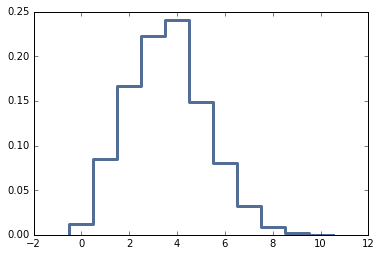

In [35]:
thinkplot.Pmf(Pmf(round1))

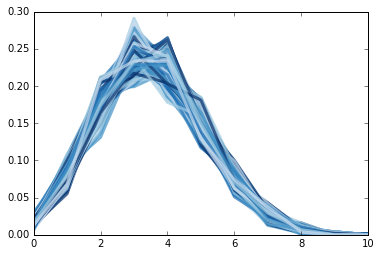

In [39]:
for wow in range(1000):
    thinkplot.Pdf(Pmf(fire_a_lot()))

In [40]:
import scipy.stats as stats

In [42]:
(stats.binom.pmf(3,10,.3) + stats.binom.pmf(3,10,.4)) / 2

0.24090939000000014